In [10]:
import os, io, shutil
import time
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
from torch import topk
from tqdm.autonotebook import tqdm

import numpy as np
from tensorboardX import SummaryWriter
from dataloader.detectiondataset import VideoDataset

import sys
sys.path.append('./src/pytorch-lr-finder')
sys.path.append('./src/kinetics_i3d_pytorch/src')
from lr_finder import LRFinder

import json
import pandas as pd

In [11]:
model_name = 'i3d'
img_size = 224
crop_size = img_size
batch_size = 1
clip_len = 16
num_classes = 1

transform = transforms.Compose([
        transforms.Resize((crop_size, crop_size)), # bilinear
        transforms.ToTensor(), #ndarray => torch.FloatTensor [0.0, 1.0].
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [-1.0, 1.0]
    ])

data_name = 'anesthesia'
dataset_path = os.getcwd()
dataset = {
    'train':VideoDataset(dataset_path, clip_len=clip_len, split='train', transform=transform, use_keypoints=True),
    'val':VideoDataset(dataset_path, clip_len=clip_len, split='val', transform=transform, use_keypoints=True),
    'test':VideoDataset(dataset_path, clip_len=clip_len, split='test', transform=transform)
}

#train: clean: 74 notclean: 62
#val:   clean:  6 notclean:  6
#test:  clean:  8 notclean:  8

Number of /data/private/minjee-video/handhygiene/images/train people: 136
Number of /data/private/minjee-video/handhygiene/images/val people: 12
Number of /data/private/minjee-video/handhygiene/images/test people: 16


In [12]:
#for phase in ['train', 'val', 'test']:
#    for i in tqdm(range(dataset[phase].__len__())):
#        rgb, flow, label = dataset[phase].__getitem__(i)
        #print(rgb.shape, flow.shape, label.shape)

# Generate partial-clips 

In [3]:
import os
from tqdm import tqdm
from dataloader.augmentation import AugmentDataset
dataset_path = os.getcwd()

#for phase in ['train', 'val', 'test']:
#    dataset = AugmentDataset(dataset_path, split=phase)
#    for i, data in enumerate(tqdm(range(dataset.__len__()))):
#        dataset.__generate_temporal_augmentation__(i)

# Visualization of Dataset

100%|██████████| 16/16 [00:00<00:00, 14428.91it/s]


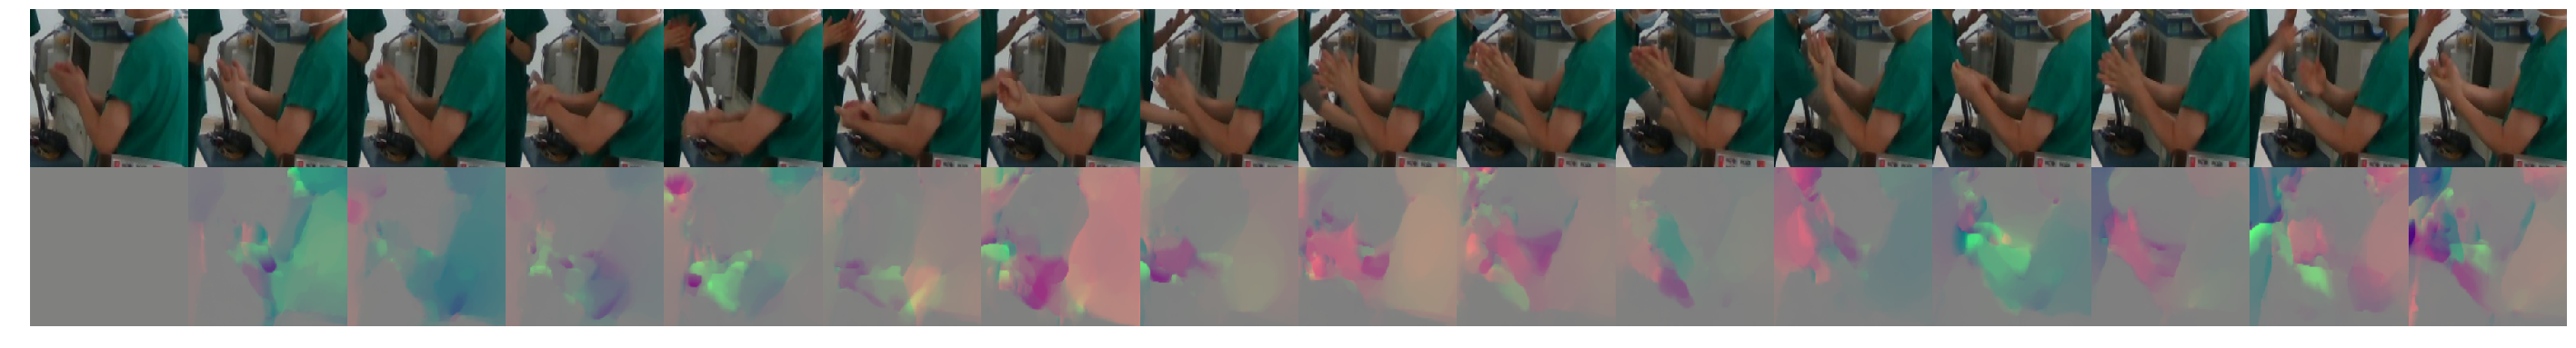

tensor([0])
/data/private/minjee-video/handhygiene/images/train/38_20190119_frames000160


In [3]:
import matplotlib.pyplot as plt


def show_dataset(item): # item: C x D x 244 x 244
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    global rgb
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    global flow
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(item[2])

i=16
show_dataset(dataset['train'].__getitem__(i))
print(dataset['train'].__getpath__(i))

In [18]:
import imageio
def generate_gif_from_npy(item, path):
    rgbs = item[0].transpose(0, 1)
    flows = item[1].transpose(0, 1)
    shape = np.asarray(flows[0]).shape
    images = []
    optflows = []
    
    for rgb in rgbs:
        images.append((np.asarray(rgb).transpose(1, 2, 0)+1)/2)
        
    tmp = np.zeros((shape[1], shape[2], 1))
    for flow in flows:
        optflows.append((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2)
        
    print(path)
    basename = os.path.basename(path)
    imgdst = '{}_rgb.gif'.format(basename)
    flowdst = '{}_flow.gif'.format(basename)
    imageio.mimsave(os.path.join(path, imgdst), images)
    imageio.mimsave(os.path.join(path, flowdst), optflows)

In [31]:
item = dataset['train'].__getitem__(40)
path = dataset['train'].__getpath__(40)
#print(path)
#generate_gif_from_npy(item, path)

100%|██████████| 23/23 [00:00<00:00, 2007.60it/s]


In [13]:
dataloaders = {
    'train': DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, num_workers=16),
    'val': DataLoader(dataset['val'], batch_size=batch_size, shuffle=False, num_workers=16),
    'test': DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, num_workers=16)
}

# Train 

In [14]:
from i3dpt import I3D, Unit3Dpy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
import copy

model_name = 'i3d'
logpath = os.path.join('./logs/', model_name)
if not os.path.exists(logpath): os.mkdir(logpath)
writer = SummaryWriter(logpath)


i3d_model_path = './src/kinetics_i3d_pytorch/'
sys.path.append(i3d_model_path)
rgb_weights_path = i3d_model_path+'model/model_rgb.pth'
flow_weights_path = i3d_model_path+'model/model_flow.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def modify_last_layer(out_channels):
    return Unit3Dpy(in_channels=1024, out_channels=out_channels, kernel_size=(1, 1, 1),
            activation=None, use_bias=True, use_bn=False)

In [16]:
i3d_rgb = I3D(num_classes=400, modality='rgb')
i3d_rgb.load_state_dict(torch.load(rgb_weights_path))
i3d_rgb.conv3d_0c_1x1 = modify_last_layer(out_channels=num_classes)
i3d_rgb.softmax = torch.nn.Sigmoid()

i3d_flow = I3D(num_classes=400, modality='flow')
i3d_flow.load_state_dict(torch.load(flow_weights_path))
i3d_flow.conv3d_0c_1x1 = modify_last_layer(out_channels=num_classes)
i3d_flow.softmax = torch.nn.Sigmoid()
i3d_flow.to(device)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    i3d_rgb = nn.DataParallel(i3d_rgb)
    i3d_flow = nn.DataParallel(i3d_flow)
i3d_rgb.to(device)
i3d_flow.to(device)

Let's use 4 GPUs!


DataParallel(
  (module): I3D(
    (conv3d_1a_7x7): Unit3Dpy(
      (pad): ConstantPad3d(padding=(2, 3, 2, 3, 2, 3), value=0)
      (conv3d): Conv3d(2, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), bias=False)
      (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxPool3d_2a_3x3): MaxPool3dTFPadding(
      (pad): ConstantPad3d(padding=(0, 1, 0, 1, 0, 0), value=0)
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=True)
    )
    (conv3d_2b_1x1): Unit3Dpy(
      (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3d_2c_3x3): Unit3Dpy(
      (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (batch3d): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxPool3

In [17]:
#criterion = F.cross_entropy
criterion = F.binary_cross_entropy
#def optimizer(model):
#    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-7)
#    lr_finder = LRFinder(model, optimizer, criterion, modality='rgb', device="cuda")
#    lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=1000, step_mode="exp")
#    lr_finder.plot()

def optimizer(model):
    return optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-7)
#optimizer(i3d_rgb)
#optimizer(i3d_flow)

In [20]:
# train by epoch
def train(dataloders, optimizer, num_epochs=50): # 
    since = time.time()
    best_model_wts = {'rgb':i3d_rgb.state_dict(), 'flow':i3d_flow.state_dict()}
    best_acc = 0.0
    iterations = {'train': 0, 'val': 0}
    
    for epoch in tqdm(range(num_epochs)):
        
        for phase in ['train', 'val']:
            if phase == 'train':
                i3d_rgb.train()
            else:
                i3d_rgb.eval()

            running_loss = 0.0
            running_corrects = {'rgb':0, 'flow':0, 'joint':0}
            
            for i, (samples) in enumerate(dataloders[phase]):
                iterations[phase] += 1
                rgbs = samples[0] #BCDHW
                flows = samples[1]
                targets = samples[2]
                
                #print(rgbs.shape, flows.shape, targets.shape)
                ##### rgb model
                optimizer(i3d_rgb).zero_grad()
                rgbs = Variable(rgbs.to(device))
                targets = Variable(targets.to(device)).float()
                
                rgb_out_vars, rgb_out_logits = i3d_rgb(rgbs)
                rgb_preds = torch.round(rgb_out_vars.data)
                #_, rgb_preds = torch.max(rgb_out_vars.data, 1)
                
                #print(rgb_out_vars.shape, rgb_preds.shape)
                ##### flow model
                optimizer(i3d_flow).zero_grad()
                flows = Variable(flows.to(device))
                
                flow_out_vars, flow_out_logits = i3d_flow(flows)
                flow_preds = torch.round(flow_out_vars.data)
                #_, flow_preds = torch.max(flow_out_vars.data, 1)
                
                #print(flow_out_vars.shape, flow_preds.shape)
                ##### joint model
                out_logit = rgb_out_logits + flow_out_logits
                # for softmax model
                #out_softmax = torch.nn.functional.softmax(out_logit, 1)
                #_, out_preds = torch.max(out_softmax, 1)
                #out_loss = criterion(out_softmax, targets.view(-1)).to(device)
                
                # for sigmoid
                out_sigmoid = torch.sigmoid(out_logit)
                print("out_sigmoid:{}".format(out_sigmoid.data))
                out_preds = torch.round(out_sigmoid.data)
                out_loss= criterion(out_sigmoid, targets).to(device)
                
                running_loss += out_loss.item() * rgbs.size(0)
                running_corrects['rgb'] += torch.sum(rgb_preds.to(device) == targets.to(device)) 
                running_corrects['flow'] += torch.sum(flow_preds.to(device) == targets.to(device)) 
                running_corrects['joint'] += torch.sum(out_preds.to(device) == targets.to(device)) 

                del rgbs, flows, out_loss, out_sigmoid#, out_softmax #
                torch.cuda.empty_cache()
            
            ## for plotting 
            # per epoch
            if phase == 'train':
                train_epoch_loss = running_loss / len(dataloaders[phase].dataset)
                train_epoch_rgb_acc = running_corrects['rgb'].double()  / len(dataloaders[phase].dataset)
                train_epoch_flow_acc = running_corrects['flow'].double()  / len(dataloaders[phase].dataset)
                train_epoch_joint_acc = running_corrects['joint'].double()  / len(dataloaders[phase].dataset)
                    
            else:
                valid_epoch_loss = running_loss / len(dataloaders[phase].dataset)
                valid_epoch_rgb_acc = running_corrects['rgb'].double() / len(dataloaders[phase].dataset)
                valid_epoch_flow_acc = running_corrects['flow'].double() / len(dataloaders[phase].dataset)
                valid_epoch_joint_acc = running_corrects['joint'].double()  / len(dataloaders[phase].dataset)
            
            # deep copy best model
            if phase == 'val' and valid_epoch_joint_acc > best_acc:
                best_acc = valid_epoch_joint_acc
                best_model_rgb_wts = copy.deepcopy(i3d_rgb.state_dict())
                best_model_flow_wts = copy.deepcopy(i3d_flow.state_dict())
                best_iters = iterations['train']
                
        writer.add_scalars('Loss', {'training': train_epoch_loss, 
                                    'validation': valid_epoch_loss}, epoch)
        writer.add_scalars('Accuracy', {'training_rgb': train_epoch_rgb_acc, 
                                        'training_flow': train_epoch_flow_acc,
                                        'training_joint': train_epoch_joint_acc,
                                        'validation_rgb': valid_epoch_rgb_acc,
                                        'validation_flow': valid_epoch_flow_acc,
                                        'validation_joint': valid_epoch_joint_acc}, epoch)
        
        torch.save(i3d_rgb.state_dict(), 
               os.path.join('./weights/{}_{}_epoch_{}.pth'.format('handhygiene', 'i3d_rgb', epoch)))
        torch.save(i3d_flow.state_dict(), 
               os.path.join('./weights/{}_{}_epoch_{}.pth'.format('handhygiene', 'i3d_flow', epoch)))
    
        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 'valid loss: {:.4f} acc: {:.4f}'.format(
                        epoch, num_epochs - 1,
                        train_epoch_loss, train_epoch_joint_acc, 
                        valid_epoch_loss, valid_epoch_joint_acc))
        
    print('Best val Acc: {:4f}'.format(best_acc))

    i3d_rgb.load_state_dict(best_model_rgb_wts)
    i3d_flow.load_state_dict(best_model_flow_wts)
    torch.save(i3d_rgb.state_dict(), 
               os.path.join('./weights/{}_{}_bestiters_{}.pth'.format('handhygiene', 'i3d_rgb', best_iters)))
    torch.save(i3d_flow.state_dict(), 
               os.path.join('./weights/{}_{}_bestiters_{}.pth'.format('handhygiene', 'i3d_flow', best_iters)))
    writer.close()
    return i3d_rgb, i3d_flow

In [21]:
train(dataloaders, optimizer, num_epochs=50)

out_sigmoid:tensor([[0.4900]], device='cuda:0')
out_sigmoid:tensor([[0.5000]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4874]], device='cuda:0')
out_sigmoid:tensor([[0.4960]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4970]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4964]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='c

out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4757]], device='cuda:0')
out_sigmoid:tensor([[0.4809]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4936]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4922]], device='cuda:0')
out_sigmoid:tensor([[0.5003]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4960]], device='cuda:0')
out_sigmoid:tensor([[0.4850]], device='cuda:0')
out_sigmoid:tensor([[0.4943]], device='cuda:0')
out_sigmoid:tensor([[0.5033]], device='cuda:0')
out_sigmoid:tensor([[0.5066]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4926]], device='c

out_sigmoid:tensor([[0.4860]], device='cuda:0')
out_sigmoid:tensor([[0.4955]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4849]], device='cuda:0')
out_sigmoid:tensor([[0.4875]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.4848]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4890]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4774]], device='cuda:0')
out_sigmoid:tensor([[0.4757]], device='cuda:0')
out_sigmoid:tensor([[0.4931]], device='c

out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4821]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.5074]], device='cuda:0')
out_sigmoid:tensor([[0.4950]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4835]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.5042]], device='cuda:0')
out_sigmoid:tensor([[0.4867]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4772]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='c

out_sigmoid:tensor([[0.4804]], device='cuda:0')
out_sigmoid:tensor([[0.5042]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4773]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4917]], device='cuda:0')
out_sigmoid:tensor([[0.4852]], device='cuda:0')
out_sigmoid:tensor([[0.4803]], device='cuda:0')
out_sigmoid:tensor([[0.4868]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.4807]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.4862]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4954]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='c

out_sigmoid:tensor([[0.4958]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4878]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.4872]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.5066]], device='cuda:0')
out_sigmoid:tensor([[0.4922]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4986]], device='cuda:0')
out_sigmoid:tensor([[0.5048]], device='cuda:0')
out_sigmoid:tensor([[0.4772]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4891]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.4973]], device='cuda:0')
out_sigmoid:tensor([[0.5042]], device='cuda:0')
out_sigmoid:tensor([[0.4821]], device='cuda:0')
out_sigmoid:tensor([[0.4861]], device='cuda:0')
out_sigmoid:tensor([[0.4804]], device='c

out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4449]], device='cuda:0')
out_sigmoid:tensor([[0.4441]], device='cuda:0')
out_sigmoid:tensor([[0.4537]], device='cuda:0')
out_sigmoid:tensor([[0.4716]], device='cuda:0')
out_sigmoid:tensor([[0.4352]], device='cuda:0')
out_sigmoid:tensor([[0.5099]], device='cuda:0')
out_sigmoid:tensor([[0.4729]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.4749]], device='cuda:0')
out_sigmoid:tensor([[0.4520]], device='cuda:0')
out_sigmoid:tensor([[0.4719]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
Epoch [6/49] train loss: 0.6937 acc: 0.5221 valid loss: 0.6781 acc: 0.5833
out_sigmoid:tensor([[0.4936]], device='cuda:0')
out_sigmoid:tensor([[0.5000]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.4821]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:t

out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.4816]], device='cuda:0')
out_sigmoid:tensor([[0.4972]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4782]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4888]], device='cuda:0')
out_sigmoid:tensor([[0.4902]], device='cuda:0')
out_sigmoid:tensor([[0.4852]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4871]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4891]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4935]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.4936]], device='c

out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4945]], device='cuda:0')
out_sigmoid:tensor([[0.4964]], device='cuda:0')
out_sigmoid:tensor([[0.4764]], device='cuda:0')
out_sigmoid:tensor([[0.5062]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4860]], device='cuda:0')
out_sigmoid:tensor([[0.4926]], device='cuda:0')
out_sigmoid:tensor([[0.4850]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4933]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4938]], device='cuda:0')
out_sigmoid:tensor([[0.4772]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4846]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4950]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='c

out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4785]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4925]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4961]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4938]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.4973]], device='cuda:0')
out_sigmoid:tensor([[0.4903]], device='cuda:0')
out_sigmoid:tensor([[0.4860]], device='cuda:0')
out_sigmoid:tensor([[0.4998]], device='cuda:0')
out_sigmoid:tensor([[0.4850]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.5026]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='c

out_sigmoid:tensor([[0.4894]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4970]], device='cuda:0')
out_sigmoid:tensor([[0.4866]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4960]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.5066]], device='cuda:0')
out_sigmoid:tensor([[0.4890]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.4922]], device='cuda:0')
out_sigmoid:tensor([[0.4902]], device='cuda:0')
out_sigmoid:tensor([[0.4872]], device='c

out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4925]], device='cuda:0')
out_sigmoid:tensor([[0.4931]], device='cuda:0')
out_sigmoid:tensor([[0.4924]], device='cuda:0')
out_sigmoid:tensor([[0.4920]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4809]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4746]], device='cuda:0')
out_sigmoid:tensor([[0.4933]], device='cuda:0')
out_sigmoid:tensor([[0.4891]], device='cuda:0')
out_sigmoid:tensor([[0.4891]], device='cuda:0')
out_sigmoid:tensor([[0.4829]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4888]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4904]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='c

out_sigmoid:tensor([[0.4984]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4949]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4924]], device='cuda:0')
out_sigmoid:tensor([[0.4814]], device='cuda:0')
out_sigmoid:tensor([[0.4786]], device='cuda:0')
out_sigmoid:tensor([[0.4838]], device='cuda:0')
out_sigmoid:tensor([[0.4743]], device='cuda:0')
out_sigmoid:tensor([[0.5045]], device='cuda:0')
out_sigmoid:tensor([[0.4765]], device='cuda:0')
out_sigmoid:tensor([[0.4291]], device='cuda:0')
out_sigmoid:tensor([[0.4227]], device='cuda:0')
out_sigmoid:tensor([[0.4333]], device='cuda:0')
out_sigmoid:tensor([[0.4718]], device='cuda:0')
out_sigmoid:tensor([[0.4270]], device='cuda:0')
out_sigmoid:tensor([[0.5075]], device='cuda:0')
out_sigmoid:tensor([[0.4625]], device='c

out_sigmoid:tensor([[0.4536]], device='cuda:0')
out_sigmoid:tensor([[0.4769]], device='cuda:0')
out_sigmoid:tensor([[0.4717]], device='cuda:0')
Epoch [14/49] train loss: 0.6931 acc: 0.5147 valid loss: 0.6785 acc: 0.5833
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4970]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4848]], device='cuda:0')
out_sigmoid:tensor([[0.4936]], device='cuda:0')
out_sigmoid:tensor([[0.4839]], device='cuda:0')
out_sigmoid:tensor([[0.4772]], device='cuda:0')
out_sigmoid:tensor([[0.5000]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.4920]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4925]], device='cuda:0')
out_sigmoid:tensor([[0.4888]], device='cuda:0')
out_sigmoid:tensor([[0.4944]], device='cuda:0')
out_sigmoid:tensor([[0.4882]], device='cuda:0')
out_sigmoid:

out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.5003]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4949]], device='cuda:0')
out_sigmoid:tensor([[0.4951]], device='cuda:0')
out_sigmoid:tensor([[0.4913]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.5117]], device='cuda:0')
out_sigmoid:tensor([[0.4938]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4852]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4884]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4804]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4746]], device='cuda:0')
out_sigmoid:tensor([[0.4861]], device='c

out_sigmoid:tensor([[0.4984]], device='cuda:0')
out_sigmoid:tensor([[0.4951]], device='cuda:0')
out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4967]], device='cuda:0')
out_sigmoid:tensor([[0.4939]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4763]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='cuda:0')
out_sigmoid:tensor([[0.4903]], device='cuda:0')
out_sigmoid:tensor([[0.4943]], device='cuda:0')
out_sigmoid:tensor([[0.5074]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.4912]], device='cuda:0')
out_sigmoid:tensor([[0.5083]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4948]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4882]], device='cuda:0')
out_sigmoid:tensor([[0.5048]], device='cuda:0')
out_sigmoid:tensor([[0.4860]], device='c

out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4970]], device='cuda:0')
out_sigmoid:tensor([[0.4953]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4986]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4874]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4916]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4978]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4867]], device='cuda:0')
out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='c

out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.4803]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.5174]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4852]], device='cuda:0')
out_sigmoid:tensor([[0.4936]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4747]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4953]], device='cuda:0')
out_sigmoid:tensor([[0.4954]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='c

out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.4895]], device='cuda:0')
out_sigmoid:tensor([[0.4794]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4774]], device='cuda:0')
out_sigmoid:tensor([[0.5067]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4715]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4891]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.4809]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.4972]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4912]], device='c

out_sigmoid:tensor([[0.4829]], device='cuda:0')
out_sigmoid:tensor([[0.4411]], device='cuda:0')
out_sigmoid:tensor([[0.4296]], device='cuda:0')
out_sigmoid:tensor([[0.4431]], device='cuda:0')
out_sigmoid:tensor([[0.4766]], device='cuda:0')
out_sigmoid:tensor([[0.4303]], device='cuda:0')
out_sigmoid:tensor([[0.5273]], device='cuda:0')
out_sigmoid:tensor([[0.4611]], device='cuda:0')
out_sigmoid:tensor([[0.4859]], device='cuda:0')
out_sigmoid:tensor([[0.4691]], device='cuda:0')
out_sigmoid:tensor([[0.4383]], device='cuda:0')
out_sigmoid:tensor([[0.4704]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='cuda:0')
Epoch [21/49] train loss: 0.6930 acc: 0.5441 valid loss: 0.6762 acc: 0.5833
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4972]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:

out_sigmoid:tensor([[0.4933]], device='cuda:0')
out_sigmoid:tensor([[0.4942]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4746]], device='cuda:0')
out_sigmoid:tensor([[0.4892]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4769]], device='cuda:0')
out_sigmoid:tensor([[0.4800]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4858]], device='c

out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4935]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4861]], device='cuda:0')
out_sigmoid:tensor([[0.5013]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4887]], device='cuda:0')
out_sigmoid:tensor([[0.4876]], device='cuda:0')
out_sigmoid:tensor([[0.4912]], device='cuda:0')
out_sigmoid:tensor([[0.4799]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4852]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.5174]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4786]], device='cuda:0')
out_sigmoid:tensor([[0.5033]], device='cuda:0')
out_sigmoid:tensor([[0.4938]], device='cuda:0')
out_sigmoid:tensor([[0.5074]], device='cuda:0')
out_sigmoid:tensor([[0.4884]], device='c

out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4972]], device='cuda:0')
out_sigmoid:tensor([[0.4974]], device='cuda:0')
out_sigmoid:tensor([[0.4912]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4900]], device='cuda:0')
out_sigmoid:tensor([[0.4916]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4937]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4655]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.4814]], device='c

out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4926]], device='cuda:0')
out_sigmoid:tensor([[0.4798]], device='cuda:0')
out_sigmoid:tensor([[0.4715]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4866]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.5013]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4710]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.4902]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='c

out_sigmoid:tensor([[0.4894]], device='cuda:0')
out_sigmoid:tensor([[0.4830]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.4850]], device='cuda:0')
out_sigmoid:tensor([[0.4860]], device='cuda:0')
out_sigmoid:tensor([[0.4911]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.4953]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='cuda:0')
out_sigmoid:tensor([[0.4807]], device='cuda:0')
out_sigmoid:tensor([[0.4956]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4963]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4961]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4970]], device='c

out_sigmoid:tensor([[0.4925]], device='cuda:0')
out_sigmoid:tensor([[0.4779]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.5009]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4862]], device='cuda:0')
out_sigmoid:tensor([[0.4854]], device='cuda:0')
out_sigmoid:tensor([[0.4963]], device='cuda:0')
out_sigmoid:tensor([[0.4798]], device='cuda:0')
out_sigmoid:tensor([[0.4395]], device='cuda:0')
out_sigmoid:tensor([[0.4401]], device='cuda:0')
out_sigmoid:tensor([[0.4514]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.4279]], device='cuda:0')
out_sigmoid:tensor([[0.5381]], device='cuda:0')
out_sigmoid:tensor([[0.4684]], device='cuda:0')
out_sigmoid:tensor([[0.4935]], device='cuda:0')
out_sigmoid:tensor([[0.4757]], device='cuda:0')
out_sigmoid:tensor([[0.4548]], device='c

Epoch [29/49] train loss: 0.6936 acc: 0.5515 valid loss: 0.6807 acc: 0.6667
out_sigmoid:tensor([[0.4866]], device='cuda:0')
out_sigmoid:tensor([[0.4974]], device='cuda:0')
out_sigmoid:tensor([[0.4950]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.4936]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4868]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.4958]], device='cuda:0')
out_sigmoid:tensor([[0.4782]], device='cuda:0')
out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4960]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.5015]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:

out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4866]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4772]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.4852]], device='cuda:0')
out_sigmoid:tensor([[0.4813]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4963]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.5042]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='cuda:0')
out_sigmoid:tensor([[0.4859]], device='cuda:0')
out_sigmoid:tensor([[0.5062]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4939]], device='c

out_sigmoid:tensor([[0.4984]], device='cuda:0')
out_sigmoid:tensor([[0.4939]], device='cuda:0')
out_sigmoid:tensor([[0.4904]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4968]], device='cuda:0')
out_sigmoid:tensor([[0.4804]], device='cuda:0')
out_sigmoid:tensor([[0.4971]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4967]], device='cuda:0')
out_sigmoid:tensor([[0.4773]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.4885]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4927]], device='cuda:0')
out_sigmoid:tensor([[0.5015]], device='cuda:0')
out_sigmoid:tensor([[0.4961]], device='cuda:0')
out_sigmoid:tensor([[0.4974]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4892]], device='cuda:0')
out_sigmoid:tensor([[0.4976]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='c

out_sigmoid:tensor([[0.4968]], device='cuda:0')
out_sigmoid:tensor([[0.4845]], device='cuda:0')
out_sigmoid:tensor([[0.5074]], device='cuda:0')
out_sigmoid:tensor([[0.4848]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4894]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4949]], device='cuda:0')
out_sigmoid:tensor([[0.4811]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4868]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4970]], device='cuda:0')
out_sigmoid:tensor([[0.4984]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='c

out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.5067]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4984]], device='cuda:0')
out_sigmoid:tensor([[0.4858]], device='cuda:0')
out_sigmoid:tensor([[0.4922]], device='cuda:0')
out_sigmoid:tensor([[0.4974]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='cuda:0')
out_sigmoid:tensor([[0.4878]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4902]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4772]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='c

out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4769]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4872]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:tensor([[0.4814]], device='cuda:0')
out_sigmoid:tensor([[0.4800]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4901]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4785]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4916]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.5036]], device='c

out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.4887]], device='cuda:0')
out_sigmoid:tensor([[0.4854]], device='cuda:0')
out_sigmoid:tensor([[0.4802]], device='cuda:0')
out_sigmoid:tensor([[0.4355]], device='cuda:0')
out_sigmoid:tensor([[0.4271]], device='cuda:0')
out_sigmoid:tensor([[0.4583]], device='cuda:0')
out_sigmoid:tensor([[0.4774]], device='cuda:0')
out_sigmoid:tensor([[0.4261]], device='cuda:0')
out_sigmoid:tensor([[0.4988]], device='cuda:0')
out_sigmoid:tensor([[0.4651]], device='cuda:0')
out_sigmoid:tensor([[0.4828]], device='cuda:0')
out_sigmoid:tensor([[0.4619]], device='cuda:0')
out_sigmoid:tensor([[0.4474]], device='cuda:0')
out_sigmoid:tensor([[0.4710]], device='cuda:0')
out_sigmoid:tensor([[0.4818]], device='cuda:0')
Epoch [36/49] train loss: 0.6914 acc: 0.5515 valid loss: 0.6809 acc: 0.5000
out_sigmoid:tensor([[0.4892]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4984]], device='cuda:0')
out_sigmoid:

out_sigmoid:tensor([[0.4839]], device='cuda:0')
out_sigmoid:tensor([[0.4743]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4746]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4980]], device='cuda:0')
out_sigmoid:tensor([[0.4856]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4816]], device='cuda:0')
out_sigmoid:tensor([[0.5015]], device='cuda:0')
out_sigmoid:tensor([[0.4799]], device='cuda:0')
out_sigmoid:tensor([[0.4891]], device='cuda:0')
out_sigmoid:tensor([[0.4827]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4788]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4958]], device='c

out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4757]], device='cuda:0')
out_sigmoid:tensor([[0.4926]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4876]], device='cuda:0')
out_sigmoid:tensor([[0.4974]], device='cuda:0')
out_sigmoid:tensor([[0.4813]], device='cuda:0')
out_sigmoid:tensor([[0.4835]], device='cuda:0')
out_sigmoid:tensor([[0.4795]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4860]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4942]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.4955]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.5067]], device='c

out_sigmoid:tensor([[0.4903]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4861]], device='cuda:0')
out_sigmoid:tensor([[0.4955]], device='cuda:0')
out_sigmoid:tensor([[0.4888]], device='cuda:0')
out_sigmoid:tensor([[0.4860]], device='cuda:0')
out_sigmoid:tensor([[0.4905]], device='cuda:0')
out_sigmoid:tensor([[0.4941]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.5000]], device='cuda:0')
out_sigmoid:tensor([[0.4950]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4859]], device='cuda:0')
out_sigmoid:tensor([[0.4803]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4912]], device='cuda:0')
out_sigmoid:tensor([[0.4884]], device='c

out_sigmoid:tensor([[0.4973]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.5067]], device='cuda:0')
out_sigmoid:tensor([[0.5070]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4916]], device='cuda:0')
out_sigmoid:tensor([[0.4894]], device='cuda:0')
out_sigmoid:tensor([[0.5015]], device='cuda:0')
out_sigmoid:tensor([[0.4923]], device='cuda:0')
out_sigmoid:tensor([[0.4803]], device='cuda:0')
out_sigmoid:tensor([[0.4746]], device='cuda:0')
out_sigmoid:tensor([[0.4756]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4867]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4914]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4884]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4809]], device='c

out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4794]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4848]], device='cuda:0')
out_sigmoid:tensor([[0.4840]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4957]], device='cuda:0')
out_sigmoid:tensor([[0.4936]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4981]], device='cuda:0')
out_sigmoid:tensor([[0.4867]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4887]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.4782]], device='c

out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4922]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.5070]], device='cuda:0')
out_sigmoid:tensor([[0.4762]], device='cuda:0')
out_sigmoid:tensor([[0.4887]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4794]], device='cuda:0')
out_sigmoid:tensor([[0.4827]], device='cuda:0')
out_sigmoid:tensor([[0.4773]], device='cuda:0')
out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='cuda:0')
out_sigmoid:tensor([[0.4968]], device='cuda:0')
out_sigmoid:tensor([[0.4318]], device='cuda:0')
out_sigmoid:tensor([[0.4284]], device='cuda:0')
out_sigmoid:tensor([[0.4397]], device='cuda:0')
out_sigmoid:tensor([[0.4712]], device='cuda:0')
out_sigmoid:tensor([[0.4039]], device='c

out_sigmoid:tensor([[0.4636]], device='cuda:0')
out_sigmoid:tensor([[0.4479]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.4871]], device='cuda:0')
Epoch [44/49] train loss: 0.6927 acc: 0.5147 valid loss: 0.6708 acc: 0.5833
out_sigmoid:tensor([[0.4848]], device='cuda:0')
out_sigmoid:tensor([[0.4820]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:tensor([[0.4833]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4972]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.5015]], device='cuda:0')
out_sigmoid:tensor([[0.4835]], device='cuda:0')
out_sigmoid:tensor([[0.4954]], device='cuda:0')
out_sigmoid:tensor([[0.4804]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4902]], device='cuda:0')
out_sigmoid:

out_sigmoid:tensor([[0.4986]], device='cuda:0')
out_sigmoid:tensor([[0.4874]], device='cuda:0')
out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4813]], device='cuda:0')
out_sigmoid:tensor([[0.5013]], device='cuda:0')
out_sigmoid:tensor([[0.4788]], device='cuda:0')
out_sigmoid:tensor([[0.4726]], device='cuda:0')
out_sigmoid:tensor([[0.4881]], device='cuda:0')
out_sigmoid:tensor([[0.4851]], device='cuda:0')
out_sigmoid:tensor([[0.4930]], device='cuda:0')
out_sigmoid:tensor([[0.4799]], device='cuda:0')
out_sigmoid:tensor([[0.4831]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='cuda:0')
out_sigmoid:tensor([[0.4953]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4972]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='cuda:0')
out_sigmoid:tensor([[0.5004]], device='c

out_sigmoid:tensor([[0.4918]], device='cuda:0')
out_sigmoid:tensor([[0.4940]], device='cuda:0')
out_sigmoid:tensor([[0.4907]], device='cuda:0')
out_sigmoid:tensor([[0.4909]], device='cuda:0')
out_sigmoid:tensor([[0.4967]], device='cuda:0')
out_sigmoid:tensor([[0.4932]], device='cuda:0')
out_sigmoid:tensor([[0.4785]], device='cuda:0')
out_sigmoid:tensor([[0.4915]], device='cuda:0')
out_sigmoid:tensor([[0.4870]], device='cuda:0')
out_sigmoid:tensor([[0.4811]], device='cuda:0')
out_sigmoid:tensor([[0.5008]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.5033]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4948]], device='cuda:0')
out_sigmoid:tensor([[0.4921]], device='cuda:0')
out_sigmoid:tensor([[0.4823]], device='cuda:0')
out_sigmoid:tensor([[0.4924]], device='cuda:0')
out_sigmoid:tensor([[0.4819]], device='cuda:0')
out_sigmoid:tensor([[0.4952]], device='c

out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.4892]], device='cuda:0')
out_sigmoid:tensor([[0.4905]], device='cuda:0')
out_sigmoid:tensor([[0.5062]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.4910]], device='cuda:0')
out_sigmoid:tensor([[0.5067]], device='cuda:0')
out_sigmoid:tensor([[0.4922]], device='cuda:0')
out_sigmoid:tensor([[0.4963]], device='cuda:0')
out_sigmoid:tensor([[0.4838]], device='cuda:0')
out_sigmoid:tensor([[0.5076]], device='cuda:0')
out_sigmoid:tensor([[0.4844]], device='cuda:0')
out_sigmoid:tensor([[0.4998]], device='cuda:0')
out_sigmoid:tensor([[0.4877]], device='cuda:0')
out_sigmoid:tensor([[0.5016]], device='cuda:0')
out_sigmoid:tensor([[0.4769]], device='cuda:0')
out_sigmoid:tensor([[0.4773]], device='cuda:0')
out_sigmoid:tensor([[0.5002]], device='cuda:0')
out_sigmoid:tensor([[0.5000]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='c

out_sigmoid:tensor([[0.4965]], device='cuda:0')
out_sigmoid:tensor([[0.4826]], device='cuda:0')
out_sigmoid:tensor([[0.4864]], device='cuda:0')
out_sigmoid:tensor([[0.4991]], device='cuda:0')
out_sigmoid:tensor([[0.4898]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4987]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.5025]], device='cuda:0')
out_sigmoid:tensor([[0.4929]], device='cuda:0')
out_sigmoid:tensor([[0.4897]], device='cuda:0')
out_sigmoid:tensor([[0.4837]], device='cuda:0')
out_sigmoid:tensor([[0.4928]], device='cuda:0')
out_sigmoid:tensor([[0.4803]], device='cuda:0')
out_sigmoid:tensor([[0.4853]], device='cuda:0')
out_sigmoid:tensor([[0.4879]], device='cuda:0')
out_sigmoid:tensor([[0.4781]], device='cuda:0')
out_sigmoid:tensor([[0.4978]], device='cuda:0')
out_sigmoid:tensor([[0.4919]], device='cuda:0')
out_sigmoid:tensor([[0.4899]], device='cuda:0')
out_sigmoid:tensor([[0.4959]], device='c

(DataParallel(
   (module): I3D(
     (conv3d_1a_7x7): Unit3Dpy(
       (pad): ConstantPad3d(padding=(2, 3, 2, 3, 2, 3), value=0)
       (conv3d): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), bias=False)
       (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (maxPool3d_2a_3x3): MaxPool3dTFPadding(
       (pad): ConstantPad3d(padding=(0, 1, 0, 1, 0, 0), value=0)
       (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=True)
     )
     (conv3d_2b_1x1): Unit3Dpy(
       (conv3d): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
       (batch3d): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (conv3d_2c_3x3): Unit3Dpy(
       (conv3d): Conv3d(64, 192, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
       (batch3d): BatchNorm3d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [10]:
flow = np.load('./images/train/clean/13_20181129_frames000808/13_20181129_frames000808.npy')

In [7]:
from glob import glob
weights_rgb = glob('./weights/handhygiene_i3d_rgb_epoch_*.pth')
weights_flow = glob('./weights/handhygiene_i3d_flow_epoch_*.pth')

In [14]:
from PIL import Image
buffer = []
for i, flw in enumerate(flow):
    shape = flw.shape
    # to make extra 3 channel to use torchvision transform
    tmp = np.empty((shape[0], shape[1], 1)).astype(np.uint8) 
    img = np.dstack((flw.astype(np.uint8), tmp))
    img = Image.fromarray(img)
    buffer.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

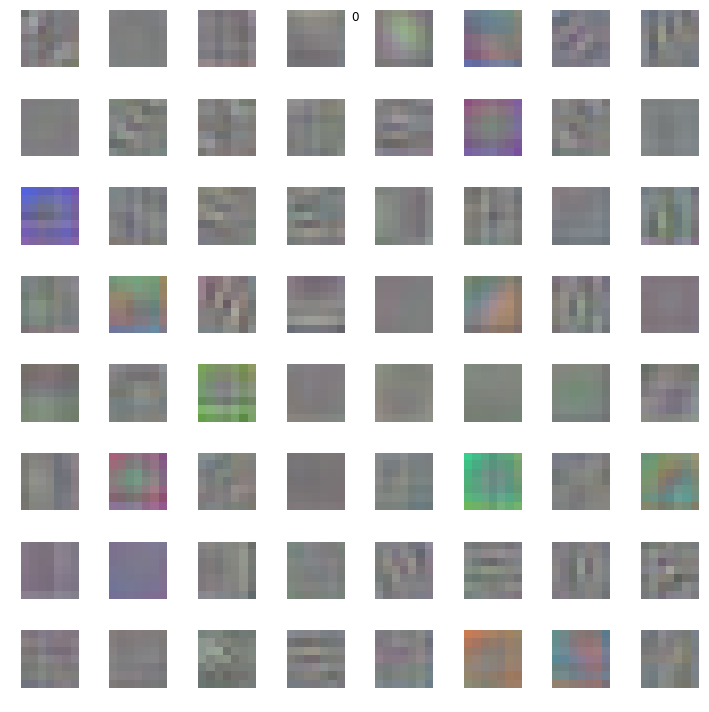

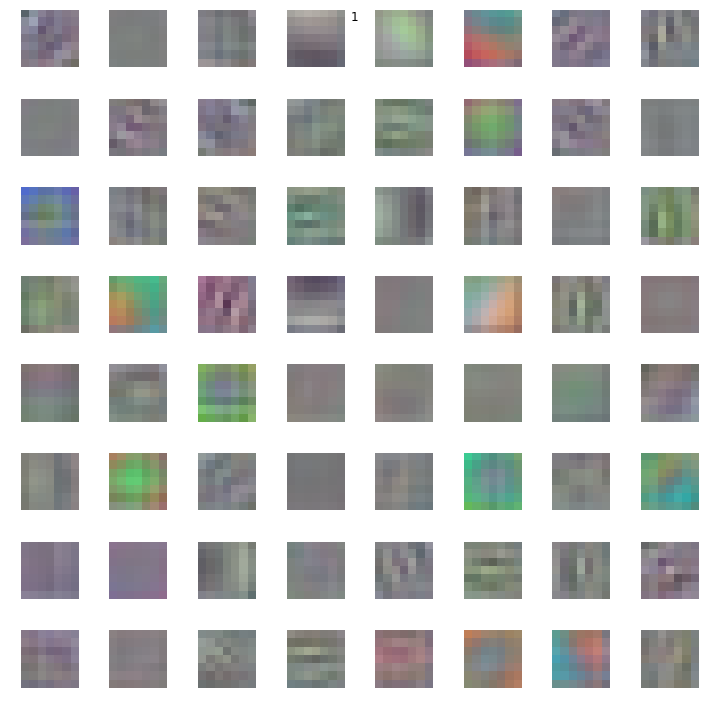

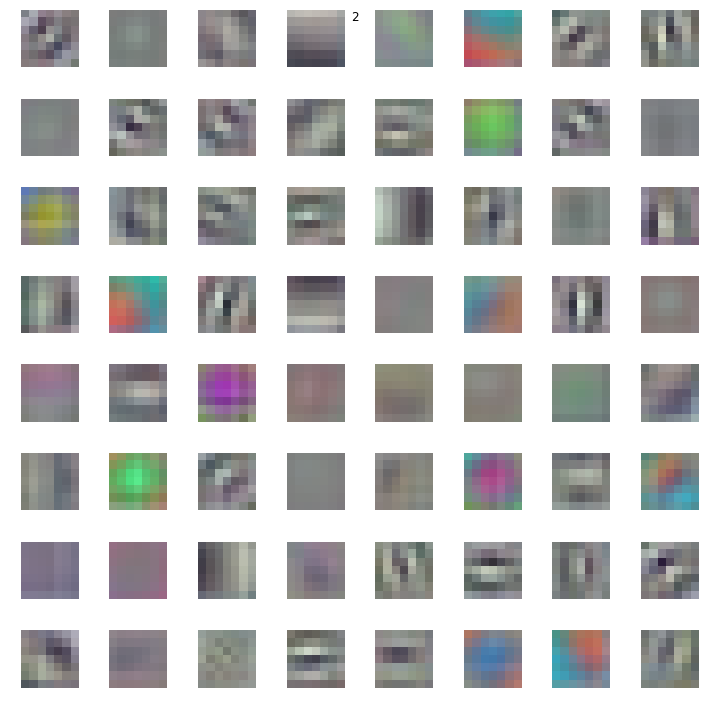

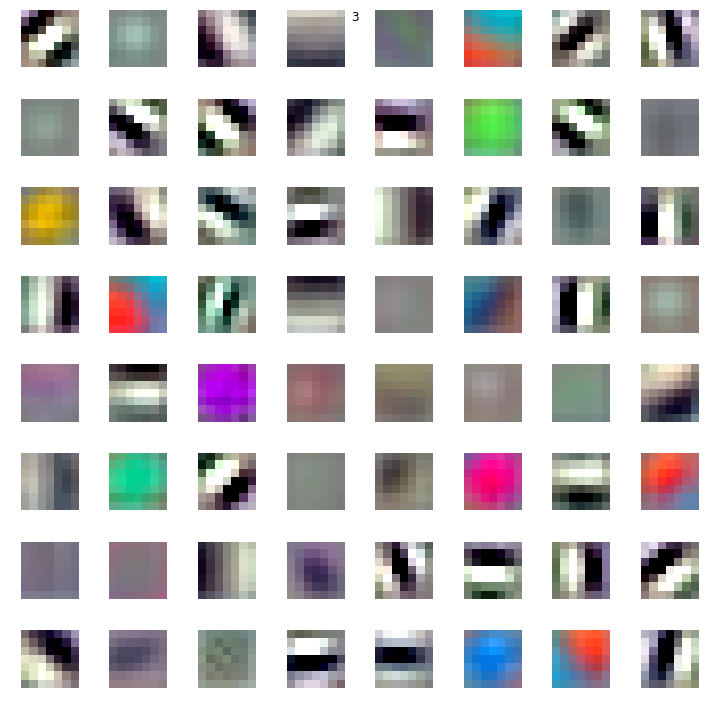

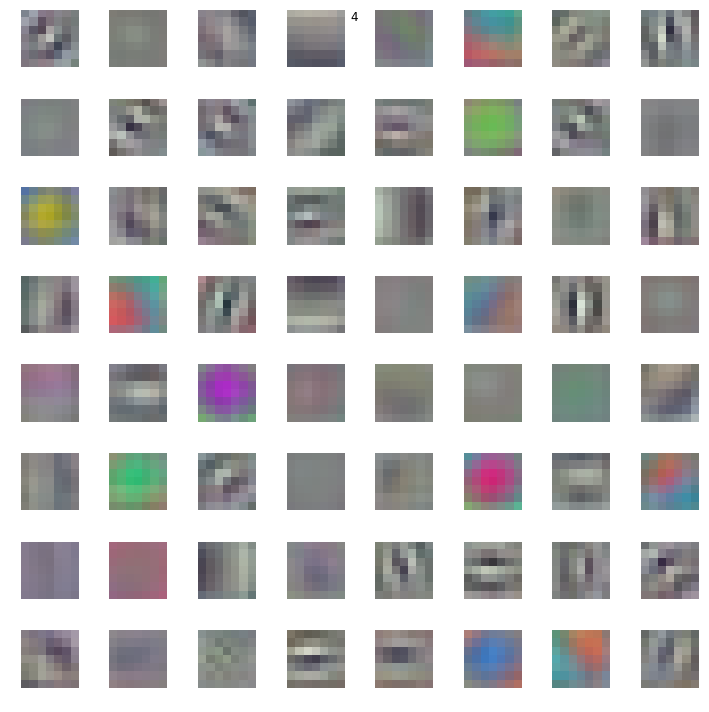

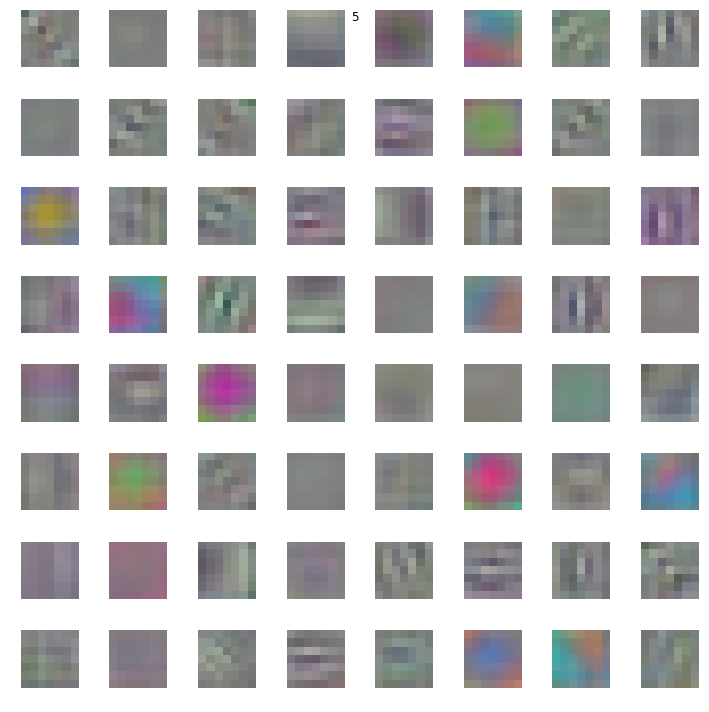

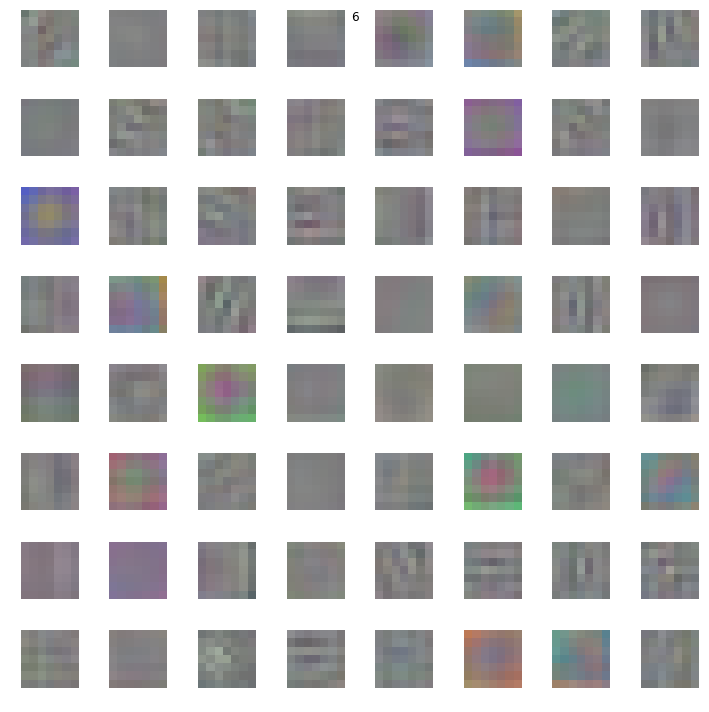

In [10]:
import matplotlib.pyplot as plt
weights = torch.load(weights_rgb[31])['conv3d_1a_7x7.conv3d.weight']
depth = weights.shape[2] # torch.Size([64, 3, 7, 7, 7])

for j in range(depth):
    fig = plt.figure(figsize=(10, 10))
    for i, weight in enumerate(weights):
        num = i+1
        ax = plt.subplot(8, 8, num)
        img = weight[:,j,:,:] # CHW
        if img.shape[0] == 3:
            img = (np.asarray(img.cpu()).transpose(1, 2, 0)+1)/2
        elif img.shape[0] == 2:
            tmp = np.zeros((img.shape[1], img.shape[2], 1))
            img = np.dstack((np.asarray(img.cpu()).transpose(1, 2, 0), tmp))
            img = (img+1)/2
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle(j)
    fig.tight_layout()
    fig.savefig("./static/img_activations_{}_rgb.jpg".format(j))
    #plt.show()

In [11]:
import imageio
images = []
for img in sorted(glob('./static/*_rgb.jpg')):
    images.append(plt.imread(img))
imageio.mimsave("./static/first_conv_rgb.gif", images, duration=1)

In [8]:
rgbs, flows, label = dataset['train'].__getitem__(100)

In [16]:
dataset['train'].__getpath__(100)

'/data/private/minjee-video/handhygiene/images/train/clean/38_20190119_frames002584_5'

In [9]:
i3d_rgb.load_state_dict(torch.load(weights_rgb[31]))
i3d_flow.load_state_dict(torch.load(weights_flow[97]))

In [9]:
# 1*64*8*112*112
act_rgbs = i3d_rgb.conv3d_1a_7x7(rgbs.unsqueeze(0).to(device))
act_flows = i3d_flow.conv3d_1a_7x7(flows.unsqueeze(0).to(device))

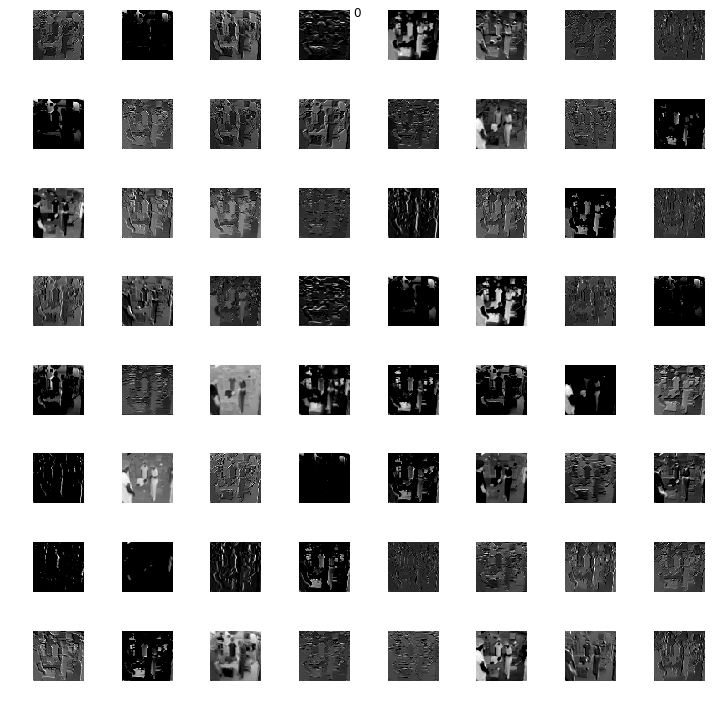

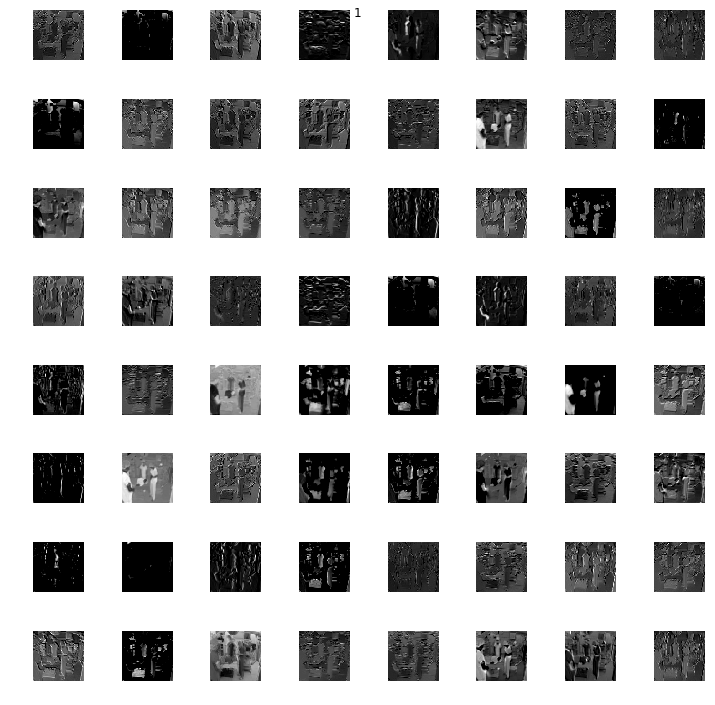

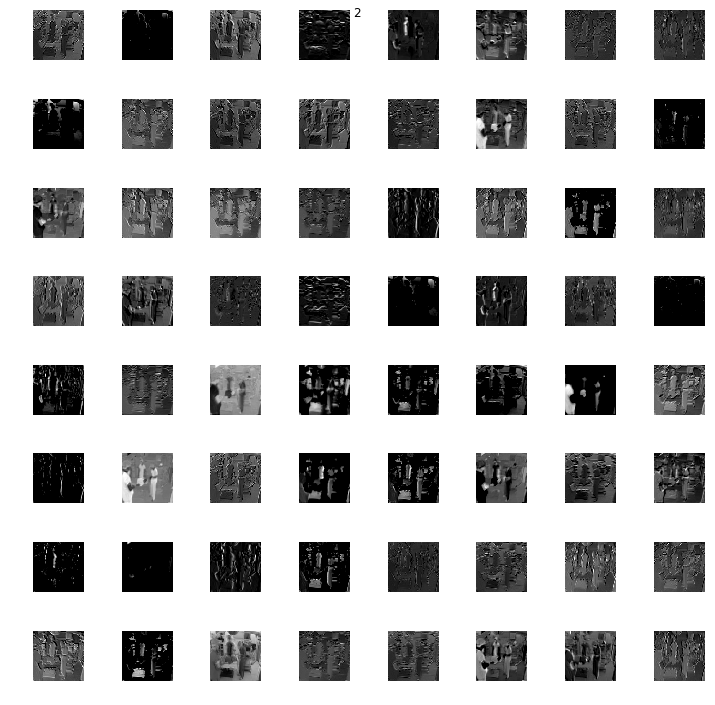

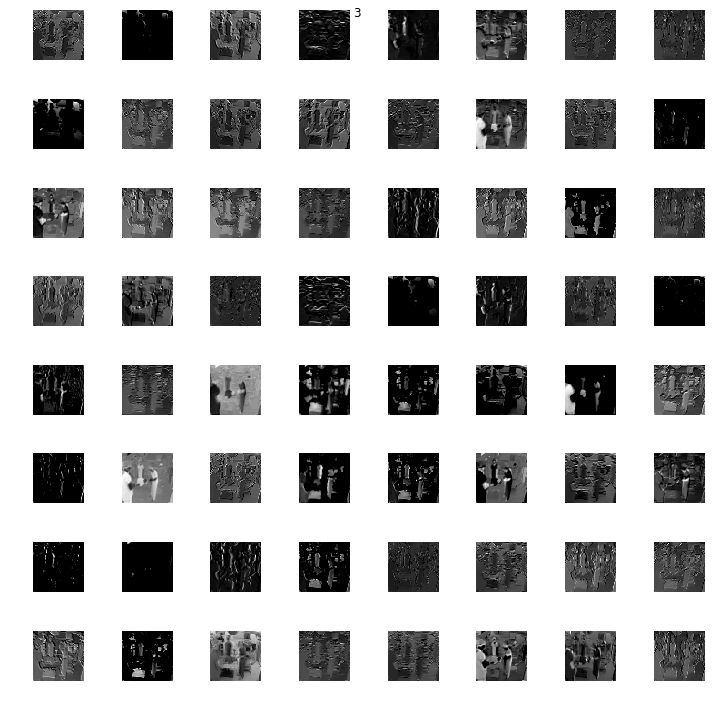

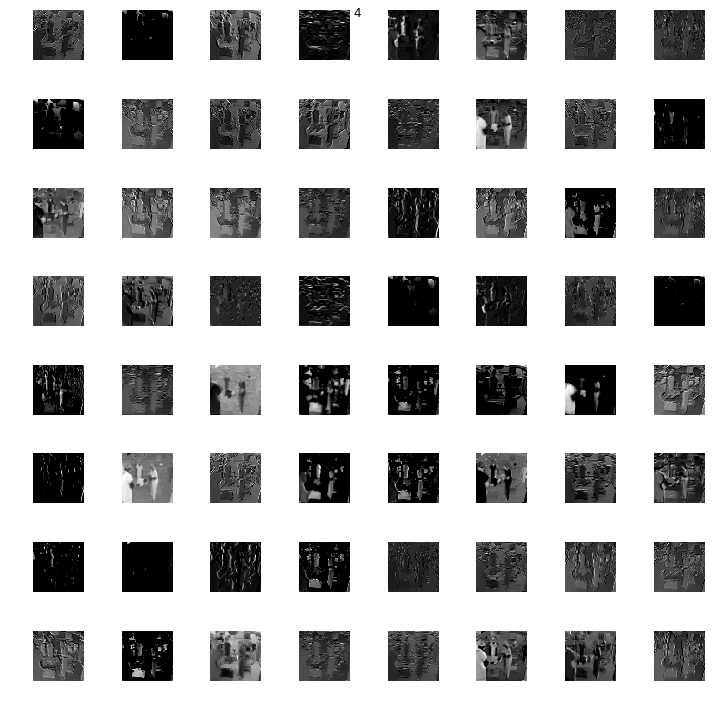

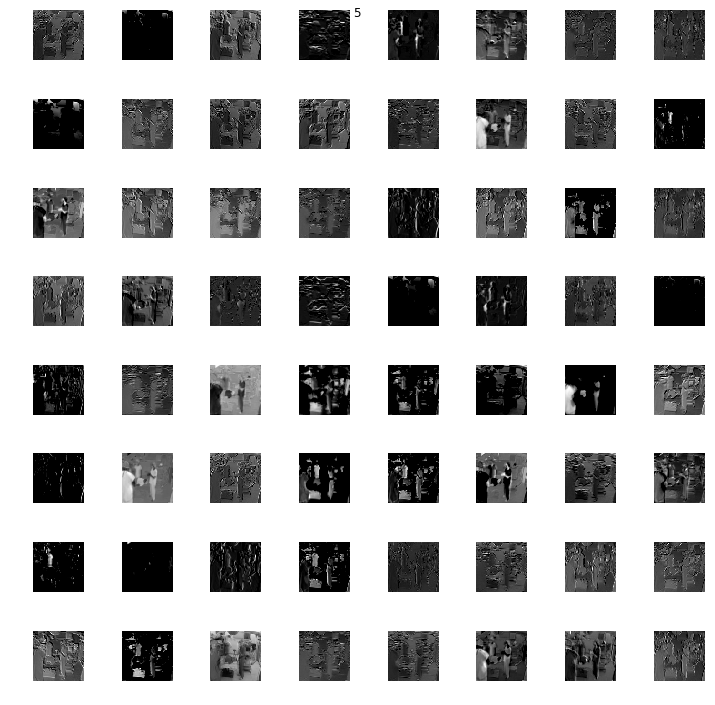

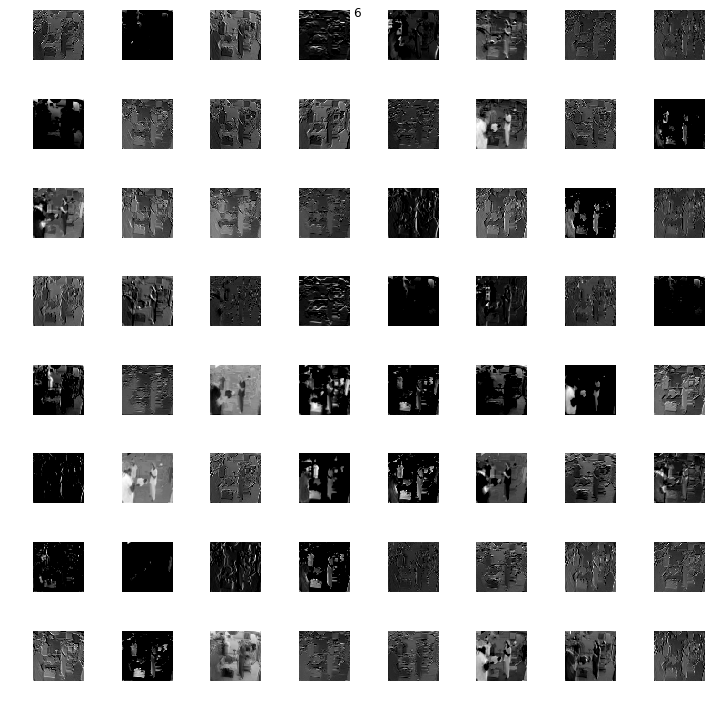

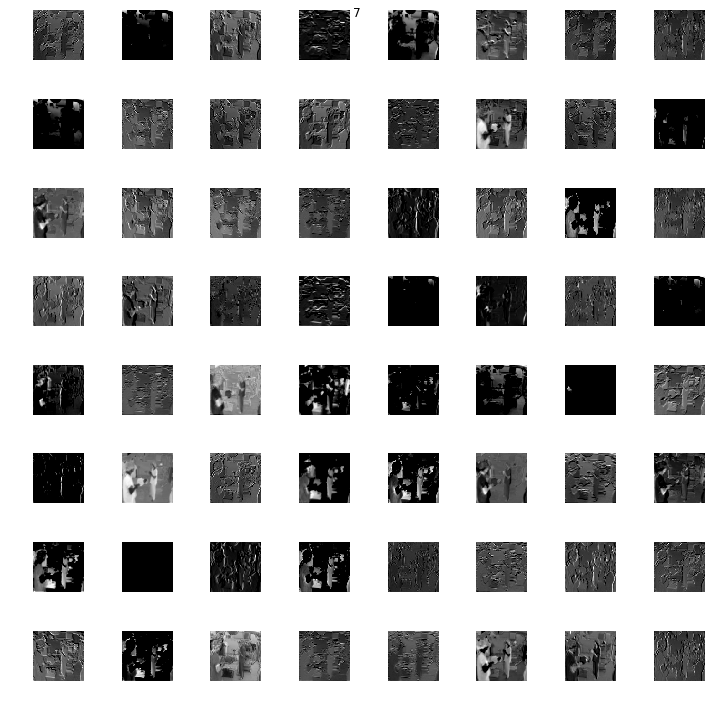

In [14]:
import matplotlib.pyplot as plt
weights = act_rgbs.squeeze(0) # 64 8 112 112
depth = weights.shape[1] #8
for d in range(depth): # 8번
    fig = plt.figure(figsize=(10, 10))
    for i, weight in enumerate(weights):
        # weight: 64x112x112
        num = i+1
        ax = plt.subplot(8, 8, num)
        img = weight[d,:,:] # CHW
        if len(img.shape) == 2:
            img = (img.cpu().detach().numpy()+1)/2
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            continue
        
        if img.shape[0] == 3:
            img = (np.asarray(img.cpu()).transpose(1, 2, 0)+1)/2
        elif img.shape[0] == 2:
            tmp = np.zeros((img.shape[1], img.shape[2], 1))
            img = np.dstack((np.asarray(img.cpu()).transpose(1, 2, 0), tmp))
            img = (img+1)/2
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle(d)
    fig.tight_layout()
    fig.savefig("./static/img_initial_activations_{}_rgb.jpg".format(d))
    #plt.show()

In [15]:
from glob import glob
import imageio
images = []
for img in sorted(glob('./static/img_initial_activations_*_rgb.jpg')):
    images.append(plt.imread(img))
imageio.mimsave("./static/first_conv_initial_activations_rgb.gif", images, duration=0.5)

In [ ]:
def get_classmap(conv_outputs, class_weights):
    conv_outputs = conv_outputs[0, :, :, :]
    classmap = np.dot(class_weights.T, conv_outputs.reshape((2048, -1)))
    classmap = classmap.reshape((32, 32))
    classmap = cv2.resize(classmap, (img_rows, img_cols))
    classmap -= np.min(classmap)
    classmap /= np.max(classmap)
    return classmap

def get_classmap_revised(model, img, class_idx):
    from keras.models import Model
    last_conv_model = Model(inputs=model.input, outputs=model.layers[-9].output) # GAP feature
    conv_outputs = last_conv_model.predict(img)
    class_weights = model.layers[int(class_idx)-6].get_weights()[0]
    final_output = get_classmap(conv_outputs, class_weights)
    return final_output